# String matching of full names
> 1. Load data with full names
> 2. Perform string matching using fuzzywuzzy

In [1]:
import sys
sys.path.insert(0, '/healthcare-fraud/src/')
import scripts as src
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
!pip install tqdm
from tqdm import tqdm_notebook
import time
from itertools import product
%matplotlib inline

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# load data
LEIE_id_full = src.read_from_efs('LEIE_id_full.csv')
PartD_id_full = src.read_from_efs('PartD_id_full.csv')
print('LEIE_id_full shape: %s, PartD_id_full shape: %s' %(LEIE_id_full.shape, PartD_id_full.shape))

LEIE_id_full shape: (14967, 7), PartD_id_full shape: (1294849, 8)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
cities = list(set(LEIE_id_full['city']).intersection(set(PartD_id_full['city'])))
print('Number of cities common to LEIE and PartD: %d' %len(cities))

Number of cities common to LEIE and PartD: 3723


In [5]:
def build_pairs(city):
    LEIE_names = LEIE_id_full['full'][LEIE_id_full['city'] == city]
    PartD_names = PartD_id_full['full'][PartD_id_full['city'] == city]
    return list(product(LEIE_names, PartD_names))

In [6]:
print("Number of available CPU cores: ")
!cat /proc/cpuinfo | grep processor | wc -l

Number of available CPU cores: 
64


In [7]:
# Build string pairs in parallel using multi-processing
processors = 64
if __name__ == '__main__':
    tasks = cities
    function = build_pairs
    with Pool(processes=processors)as p:
        pairs = list(tqdm_notebook(p.imap(function, tasks), total=len(tasks)))
        
# make a dictionary before converting
city_pairs_dict = {}
for i, city in enumerate(cities):
    city_pairs_dict[city] = pairs[i]

# unpack name pairs
pairs = []
for city in cities:
    pairs += city_pairs_dict[city]
print('There are %s million pairs!' %round(len(pairs)/1000000,1))


There are 26.0 million pairs!


## String matching using Fuzzywuzzy
---

In [8]:
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz

def get_fuzz_scores(str_pair):
    str_a = str_pair[0]
    str_b = str_pair[1]
    fuzz_scores = [fuzz.QRatio(str_a,str_b),
                   fuzz.UQRatio(str_a,str_b),
                   fuzz.UWRatio(str_a,str_b),
                   fuzz.WRatio(str_a,str_b),                        
                   fuzz.partial_ratio(str_a,str_b),
                   fuzz.partial_token_sort_ratio(str_a,str_b),                  
                   fuzz.token_set_ratio(str_a,str_b),
                   fuzz.token_sort_ratio(str_a,str_b)]
    return fuzz_scores

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [9]:
pairs[:10]

[('WASSERMAN RENEE PODIATRY COMMACK',
  'WITANOWSKI STEPHEN Internal Medicine COMMACK'),
 ('WASSERMAN RENEE PODIATRY COMMACK', 'RUSSO EDWARD Dentist COMMACK'),
 ('WASSERMAN RENEE PODIATRY COMMACK',
  'STURM ELIZABETH Internal Medicine COMMACK'),
 ('WASSERMAN RENEE PODIATRY COMMACK', 'ROSARIO JEFFREY Dentist COMMACK'),
 ('WASSERMAN RENEE PODIATRY COMMACK', 'STERGAKOS PETER Dentist COMMACK'),
 ('WASSERMAN RENEE PODIATRY COMMACK', 'BLAU KAREN Internal Medicine COMMACK'),
 ('WASSERMAN RENEE PODIATRY COMMACK',
  'PILLAI PRABHA Internal Medicine COMMACK'),
 ('WASSERMAN RENEE PODIATRY COMMACK',
  'FRENDO CHRISTOPHER Orthopedic Surgery COMMACK'),
 ('WASSERMAN RENEE PODIATRY COMMACK',
  'SUGARMAN STEVEN Medical Oncology COMMACK'),
 ('WASSERMAN RENEE PODIATRY COMMACK', 'GREEN STEVEN Dentist COMMACK')]

In [10]:
# Get fuzzy wuzzy scores in parallel using multi-processing
if __name__ == '__main__':
    tasks = pairs
    function = get_fuzz_scores
    with Pool(processes=64)as p:
        fuzz_scores = list(tqdm_notebook(p.imap(function, tasks), total=len(tasks)))

In [12]:
# create pandas dataframe for fuzz scores
s_time = time.time()
columns = ['Qratio',
           'UQratio',
           'UWQratio',
           'WRatio',
           'partial_ratio',
           'partial_token_sort_ratio',
           'token_set_ratio',
           'token_sort_ratio']
fuzz_scores_df = pd.DataFrame(data = fuzz_scores, index=None, columns=columns)

# add names from LEIE and Part
fuzz_scores_df['LEIE'] = np.array(pairs).T[0]
fuzz_scores_df['PartD'] = np.array(pairs).T[1]

# save to efs
src.save_to_efs(fuzz_scores_df, 'fuzz_scores_df.csv')
e_time = time.time()
e_time - s_time

# save to efs
src.save_to_efs(fuzz_scores_df, 'fuzz_scores_df.csv')
e_time = time.time()
e_time - s_time

708.0314316749573

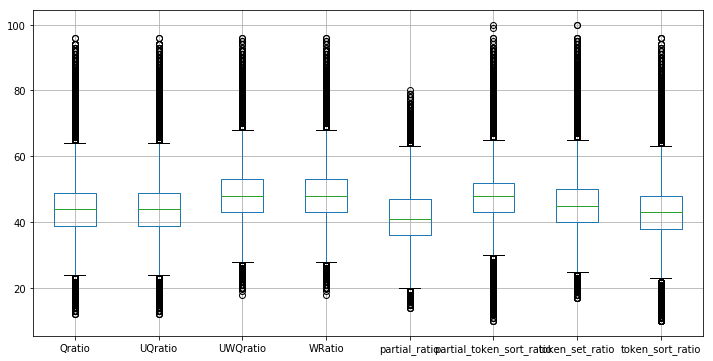

In [13]:
fuzz_scores_df.boxplot(figsize=(12,6))
plt.show()